In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import ElasticNet, ElasticNetCV, Ridge, Lasso
from sklearn.datasets import make_regression # for dataset generation
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler # for feature scaling
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [2]:
X, y, true_coef = make_regression(
    n_samples=200,      # 200 rows
    n_features=50,      # 50 features total
    n_informative=10,   # only 10 actually matter
    noise=20,
    coef=True,
    random_state=42
)

print("X shape:", X.shape)   # (200, 50)
print("y shape:", y.shape)   # (200,)

X shape: (200, 50)
y shape: (200,)


In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)  # fit on train only!
X_test  = scaler.transform(X_test)       # transform test with train's stats

Why scale? The L1/L2 penalty punishes large coefficients. If feature A is in millions and feature B is in 0–1, the penalty unfairly hurts A. Scaling fixes this.


In [4]:
def elastic_net_loss(y_true, y_pred, beta, alpha=1.0, l1_ratio=0.5):
    rss    = np.sum((y_true - y_pred) ** 2)               # fit quality
    l1_pen = alpha * l1_ratio * np.sum(np.abs(beta))       # sparsity
    l2_pen = alpha * (1 - l1_ratio) / 2 * np.sum(beta**2) # shrinkage
    return rss + l1_pen + l2_pen

# Formula:  Loss = RSS  +  α·ρ·Σ|β|  +  α·(1-ρ)/2·Σβ²
#                           ↑ L1             ↑ L2

Sparsity in machine learning refers to data, vectors, or model weights that contain mostly zero or near-zero values. It signifies that only a small subset of features or parameters are active or relevant, which enhances computational efficiency, reduces memory storage, and aids in model interpretability

alpha controls overall penalty strength. l1_ratio controls the L1 vs L2 mix.


In [5]:
model = ElasticNet(
    alpha=1.0,       # regularization strength
    l1_ratio=0.5,    # 50% L1, 50% L2
    max_iter=5000
)
model.fit(X_train, y_train)

print("Non-zero coefficients:", np.sum(model.coef_ != 0), "out of 50")
print("Zeroed out features  :", np.sum(model.coef_ == 0), "out of 50")

Non-zero coefficients: 48 out of 50
Zeroed out features  : 2 out of 50


The zeroed-out features are the ones Elastic Net decided were useless — automatic feature selection!

In [6]:
cv_model = ElasticNetCV(
    l1_ratio = [0.1, 0.3, 0.5, 0.7, 0.9, 1.0],  # try these mixes
    alphas   = np.logspace(-3, 1, 50),             # try 50 alpha values
    cv       = 5,                                  # 5-fold cross validation
    max_iter = 5000
)
cv_model.fit(X_train, y_train)

print("Best alpha    :", cv_model.alpha_)
print("Best l1_ratio :", cv_model.l1_ratio_)

Best alpha    : 1.0481131341546852
Best l1_ratio : 1.0


## What These Values Mean
l1_ratio = 1.0 → pure Lasso (no Ridge component at all)
alpha = 1.048 → moderate regularization strength
So ElasticNetCV tried all your l1_ratio options and concluded — "I don't need any L2 penalty, L1 alone works best for this data."

Never guess alpha manually. Let CV find the best value. Always prefer ElasticNetCV over ElasticNet in real projects.

For every alpha value, it:

Splits your training data into 5 folds
Trains on 4 folds, validates on the 1 remaining
Does this 5 times so every fold gets tested
Averages the error across all 5 runs
Picks the alpha with the lowest average validation error

So it tries 50 × 5 = 250 fits and returns the winner. You'd never do this by hand.


Because you can't just try alphas on the test set — that's data leakage. You'd be choosing alpha based on test performance, which means your test score is no longer an honest evaluation.

ElasticNet is a tool. ElasticNetCV is that tool + an automatic calibration system. In real projects, calibration is the hard part — so let the computer do it.

Bottom Line
Your resultMeaning 
l1_ratio = 1.0----> Features are independent, sparse signal
l1_ratio = 0.5---->Mix of correlated + sparse features
l1_ratio = 0.0---->Heavily correlated features, Ridge is better

In [7]:
y_pred = cv_model.predict(X_test)

mse  = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5
mae  = mean_absolute_error(y_test, y_pred)
r2   = r2_score(y_test, y_pred)

print(f"MSE  : {mse:.2f}")    # avg squared error (sensitive to outliers)
print(f"RMSE : {rmse:.2f}")   # same units as y — most interpretable
print(f"MAE  : {mae:.2f}")    # avg absolute error — robust to outliers
print(f"R²   : {r2:.4f}")     # % variance explained (1.0 = perfect)

MSE  : 481.85
RMSE : 21.95
MAE  : 16.95
R²   : 0.9595


MetricPlain EnglishR² = 0.9595Model is 96% accurate in explaining the data — very goodRMSE = 21.95Average prediction is off by ~22 units — your main error gaugeMAE = 16.95Most predictions off by ~17 units — robust view of typical errorMSE = 481.85Just RMSE² — ignore this for interpretation, it's for math

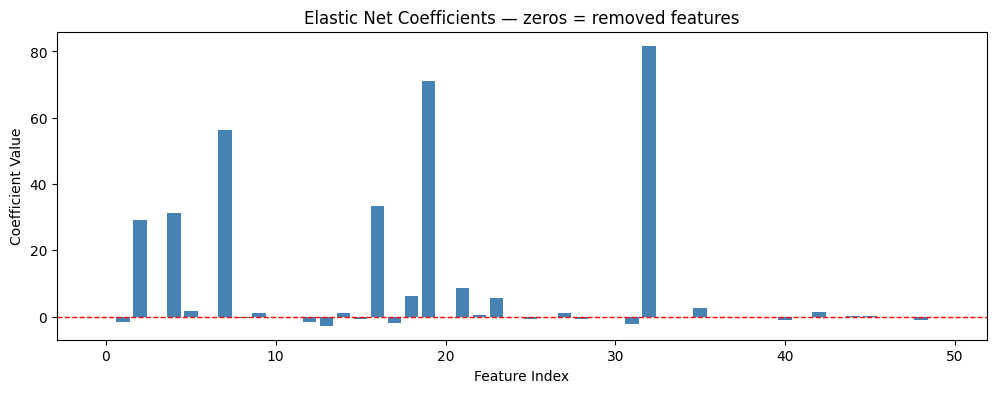

In [9]:
plt.figure(figsize=(12, 4))
plt.bar(range(len(cv_model.coef_)), cv_model.coef_, color='steelblue')
plt.axhline(0, color='red', lw=1, linestyle='--')
plt.xlabel("Feature Index")
plt.ylabel("Coefficient Value")
plt.title("Elastic Net Coefficients — zeros = removed features")
plt.show()

Bars at 0 = features the model discarded. The tall bars = features that truly drive predictions.


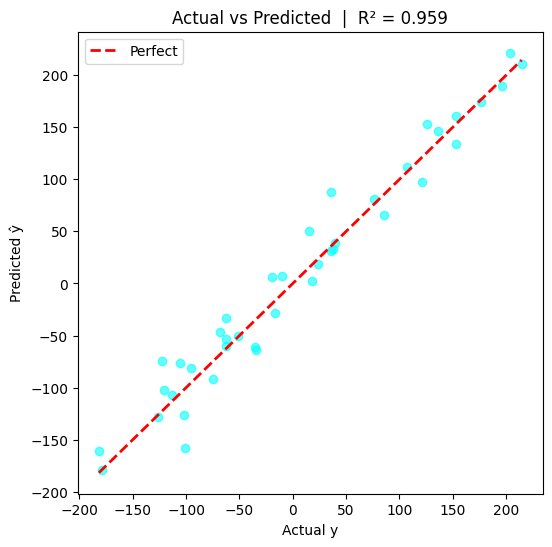

In [10]:
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred, alpha=0.6, color='cyan')
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()], 'r--', lw=2, label='Perfect')
plt.xlabel("Actual y")
plt.ylabel("Predicted ŷ")
plt.title(f"Actual vs Predicted  |  R² = {r2:.3f}")
plt.legend()
plt.show()

Points close to the red diagonal = good predictions. Scatter away from it = errors.


# l1_ratio = 0.0  → pure Ridge  (no zeros, smooth shrinkage)
# l1_ratio = 0.5  → Elastic Net (some zeros, balanced)
# l1_ratio = 1.0  → pure Lasso  (aggressive zeroing)

# Rule of thumb:
# - Many correlated features?  → l1_ratio around 0.5
# - Want aggressive selection? → l1_ratio closer to 1.0
# - Features mostly independent? → try Lasso (l1_ratio=1.0)

Quick mental model:

Alpha ↑ → stronger penalty → simpler model → more zeros
l1_ratio → 1 → more like Lasso → more aggressive zeroing
l1_ratio → 0 → more like Ridge → smooth shrinkage, no zeros